In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Read the risk factors, industry portfolios, and market portfolio data, dropping the 'Date' column
# rf = pd.read_excel("excel_data/Risk_Factors.xlsx").drop(columns="Date")
# industry_p = pd.read_excel("excel_data/Industry_Portfolios.xlsx").drop(columns="Date")
# market_p = pd.read_excel("excel_data/Market_Portfolio.xlsx").drop(columns="Date")
df_industries = pd.read_excel('./Homework_4/data/Industry_Portfolios.xlsx', index_col='Date')
df_market = pd.read_excel('./Homework_4/data/Market_Portfolio.xlsx', index_col='Date')
df_risk_factors = pd.read_excel('./Homework_4/data/Risk_Factors.xlsx', index_col='Date')

def ff3_factor(data_portfolio: pd.DataFrame, data_market: pd.DataFrame, risk_factors: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Fama-French Three-Factor model coefficients for each portfolio.
    
    Formula:
    Fama-French 3-Factor Model:
    R̃i − Rf = αi + βi (R̃m − Rf) + γi (R̃s - R̃b) + δi (R̃h - R̃l) + ϵ̃i
    
    where:
    - R̃i is the return on the portfolio i.
    - Rf is the risk-free rate.
    - αi is the alpha, capturing unexplained returns.
    - βi, γi, δi are sensitivities to the market, size (SMB), and value (HML) factors, respectively.
    - ϵ̃i represents idiosyncratic error or asset-specific risk.
    
    Parameters:
    data_portfolio (pd.DataFrame): Portfolio returns
    data_market (pd.DataFrame): Market returns
    risk_factors (pd.DataFrame): Risk factors including 'Rm-Rf', 'SMB', 'HML', 'Rf'
    
    Returns:
    pd.DataFrame: DataFrame containing Alpha, Beta (Rm-Rf), Beta (SMB), Beta (HML), and R-squared for each portfolio
    """
    # Make a copy of the portfolio data and align the index with risk factors
    data_portfolio = data_portfolio.copy()
    data_portfolio.index = risk_factors.index

    # Extract the Fama-French factors: Market excess return (Rm-Rf), SMB (size factor), HML (value factor)
    data_factors = risk_factors[['Rm-Rf', 'SMB', 'HML']].values
    # Calculate excess returns by subtracting the risk-free rate from the portfolio returns
    excess_returns = data_portfolio.subtract(risk_factors['Rf'], axis=0)

    # Fit a linear regression model for each portfolio against the three Fama-French factors
    models = [LinearRegression().fit(data_factors, excess_returns[col]) for col in excess_returns.columns]
    # Create a DataFrame to store the regression coefficients and R-squared values
    ff_table = pd.DataFrame({
        'Alpha': [model.intercept_ for model in models],
        'Beta (Rm-Rf)': [model.coef_[0] for model in models],
        'Beta (SMB)': [model.coef_[1] for model in models],
        'Beta (HML)': [model.coef_[2] for model in models],
        'R-squared': [model.score(data_factors, excess_returns[col]) for model, col in zip(models, excess_returns.columns)]
    }, index=excess_returns.columns)

    return ff_table

def calculate_performance_metrics(excess_returns: pd.DataFrame, risk_factors: pd.DataFrame, capm_betas: pd.Series, ff_alphas: pd.Series) -> pd.DataFrame:
    """
    Calculate performance metrics for each portfolio.
    
    Parameters:
    excess_returns (pd.DataFrame): Excess returns of portfolios
    risk_factors (pd.DataFrame): Risk factors including 'Rm-Rf'
    capm_betas (pd.Series): CAPM beta values
    ff_alphas (pd.Series): Fama-French alpha values
    
    Returns:
    pd.DataFrame: DataFrame containing Sharpe Ratio, Sortino Ratio, Treynor Ratio, Jensen's Alpha, and FF Three-Factor Alpha
    """
    # Calculate the mean excess return and standard deviation for each portfolio
    mean_excess_returns = excess_returns.mean()
    std_devs = excess_returns.std(ddof=1)
    
    # Calculate downside risk by considering only negative returns
    downside_returns = excess_returns.where(excess_returns < 0)
    semi_variances = downside_returns.pow(2).mean()
    semi_std_devs = np.sqrt(semi_variances)
    
    # Compute Sharpe, Sortino, and Treynor ratios
    sharpe_ratios = mean_excess_returns / std_devs
    sortino_ratios = mean_excess_returns / semi_std_devs
    treynor_ratios = mean_excess_returns / capm_betas
    
    # Calculate Jensen's Alpha for each portfolio using CAPM
    jensens_alphas = {}
    for industry in excess_returns.columns:
        Y = excess_returns[industry].dropna()
        X = sm.add_constant(risk_factors['Rm-Rf'].loc[Y.index])
        capm_model = sm.OLS(Y, X).fit()
        jensens_alphas[industry] = capm_model.params['const']
    
    # Compile all performance metrics into a DataFrame
    performance_metrics = pd.DataFrame({
        'Sharpe Ratio': sharpe_ratios,
        'Sortino Ratio': sortino_ratios,
        'Treynor Ratio': treynor_ratios,
        "Jensen's Alpha": pd.Series(jensens_alphas),
        "FF Three-Factor Alpha": ff_alphas
    })

    return performance_metrics.astype(float)

def calculate_performance_metrics2(excess_returns: pd.DataFrame, risk_factors: pd.DataFrame, capm_betas: pd.Series, ff_alphas: pd.Series, benchmark_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate performance metrics for each portfolio.

    Formulas:
    - Sharpe Ratio: Si = E(R̃i − Rf) / √Var(R̃i − Rf)
    - Sortino Ratio: Sti = E(R̃i − R̃t) / √SV(R̃i; R̃t)
      - Where SV denotes the downside semi-variance: E[min{R̃i − R̃t, 0}^2]
    - Treynor Ratio: Ti = E(R̃i − Rf) / βi
    - Jensen's Alpha: αi = E(R̃i − Rf) - βi E(R̃m − Rf)
    - Information Ratio: Ii = E(R̃i - R̃t) / √Var(R̃i - R̃t)
    - Fama-French Alpha (provided as ff_alphas).

    Parameters:
    excess_returns (pd.DataFrame): Excess returns of portfolios.
    risk_factors (pd.DataFrame): Risk factors including 'Rm-Rf'.
    capm_betas (pd.Series): CAPM beta values.
    ff_alphas (pd.Series): Fama-French alpha values.
    benchmark_returns (pd.DataFrame): Benchmark returns for Information Ratio.

    Returns:
    pd.DataFrame: DataFrame containing Sharpe Ratio, Sortino Ratio, Treynor Ratio, Jensen's Alpha, Information Ratio, and FF Alpha.
    """
    # Calculate the mean excess return and standard deviation for each portfolio
    mean_excess_returns = excess_returns.mean()
    std_devs = excess_returns.std(ddof=1)
    
    # Downside semi-variance calculation for Sortino Ratio
    downside_returns = excess_returns.where(excess_returns < 0)
    semi_variances = downside_returns.pow(2).mean()
    semi_std_devs = np.sqrt(semi_variances)
    
    # Compute Sharpe, Sortino, and Treynor ratios
    sharpe_ratios = mean_excess_returns / std_devs
    sortino_ratios = mean_excess_returns / semi_std_devs
    treynor_ratios = mean_excess_returns / capm_betas
    
    # Calculate Jensen's Alpha for each portfolio using CAPM
    jensens_alphas = {}
    for industry in excess_returns.columns:
        Y = excess_returns[industry].dropna()
        X = sm.add_constant(risk_factors['Rm-Rf'].loc[Y.index])
        capm_model = sm.OLS(Y, X).fit()
        jensens_alphas[industry] = capm_model.params['const']
    
    # Calculate Information Ratio using tracking error relative to benchmark
    tracking_error = excess_returns.subtract(benchmark_returns.mean(axis=1), axis=0).std(ddof=1)
    information_ratios = mean_excess_returns / tracking_error

    # Compile all performance metrics into a DataFrame
    performance_metrics = pd.DataFrame({
        'Sharpe Ratio': sharpe_ratios,
        'Sortino Ratio': sortino_ratios,
        'Treynor Ratio': treynor_ratios,
        "Jensen's Alpha": pd.Series(jensens_alphas),
        "Information Ratio": information_ratios,
        "FF Three-Factor Alpha": ff_alphas
    })

    return performance_metrics.astype(float)

def capm_alpha_beta(industry_returns: pd.DataFrame, market_returns: pd.DataFrame, risk_free: pd.Series) -> tuple:
    """
    Calculate CAPM alpha and beta for each industry portfolio.
    
    Parameters:
    industry_returns (pd.DataFrame): Returns of industry portfolios
    market_returns (pd.DataFrame): Market returns
    risk_free (pd.Series): Risk-free rate
    
    Returns:
    tuple: (excess_returns, capm_betas, jensens_alphas)
    """
    # Calculate excess returns by subtracting the risk-free rate
    excess_returns = industry_returns.subtract(risk_free, axis=0)
    # Calculate market excess returns and rename the column for clarity
    market_excess_returns = market_returns.subtract(risk_free, axis=0).rename(columns=lambda x: 'Rm_minus_Rf')
    
    capm_betas = {}
    jensens_alphas = {}
    
    # For each industry portfolio, fit the CAPM model to obtain beta and alpha
    for industry in excess_returns.columns:
        Y = excess_returns[industry].dropna()
        X = sm.add_constant(market_excess_returns['Rm_minus_Rf'].loc[Y.index])
        capm_model = sm.OLS(Y, X).fit()
        capm_betas[industry] = capm_model.params['Rm_minus_Rf']
        jensens_alphas[industry] = capm_model.params['const']
    
    return excess_returns, pd.Series(capm_betas), pd.Series(jensens_alphas)

def plot_performance_metrics(performance_metrics: pd.DataFrame, metrics_to_plot: list = None):
    """
    Plot specified performance metrics as bar charts.
    
    Parameters:
    performance_metrics (pd.DataFrame): DataFrame containing performance metrics
    metrics_to_plot (list, optional): List of metric names to plot. Defaults to ['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio'].
    """
    if metrics_to_plot is None:
        metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        performance_metrics[metric].plot(kind='bar', color="skyblue", edgecolor='black')
        plt.title(f'{metric} for Industry Portfolios')
        plt.ylabel(metric)
        plt.xlabel('Industry Portfolios')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()



/Users/ju/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/ju/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/ju/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


          Alpha  Beta (Rm-Rf)  Beta (SMB)  Beta (HML)
NoDur  0.386704      0.712134   -0.229102   -0.023342
Durbl -0.474342      1.447452    0.670878    0.240949
Manuf  0.153285      1.142282    0.087388    0.027727
Enrgy  0.523007      1.028354   -0.259360   -0.008158
HiTec -0.065979      1.152803    0.335674   -0.556947
Telcm  0.200724      0.924137   -0.080299   -0.019063
Shops  0.255941      0.770227    0.280191   -0.039080
Hlth   0.257472      0.751976   -0.212655   -0.143765
Utils  0.474411      0.631827   -0.387961   -0.016881
Other -0.404412      1.123473   -0.061676    0.547325
       Sharpe Ratio  Sortino Ratio  Treynor Ratio  Jensen's Alpha  \
NoDur      0.231099       0.212422       1.186372        0.369717   
Durbl      0.072356       0.074411       0.367463       -0.417903   
Manuf      0.166616       0.144420       0.758251        0.160494   
Enrgy      0.181708       0.167552       1.143330        0.504485   
HiTec      0.118552       0.111231       0.564295       -0.06

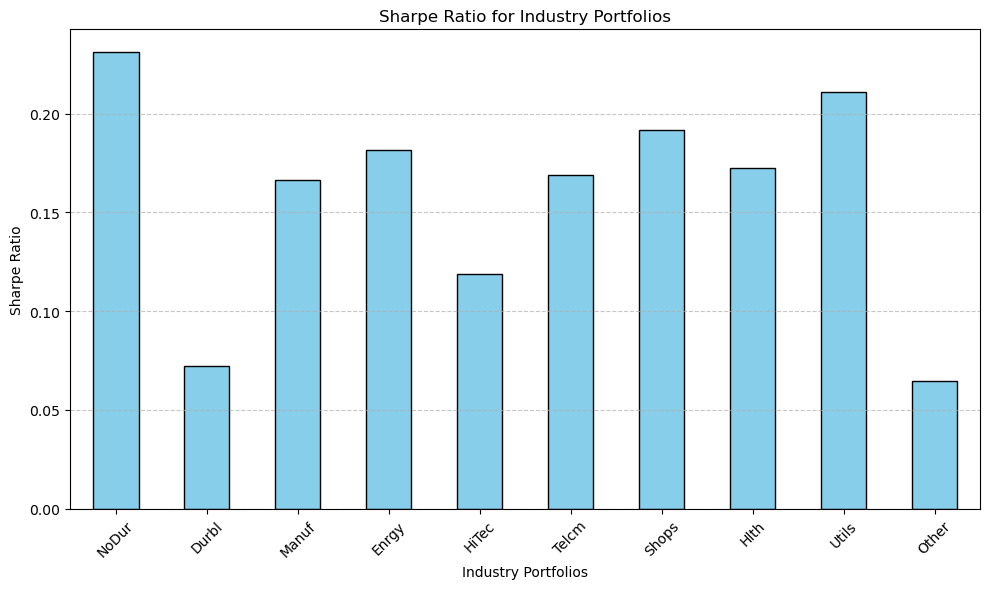

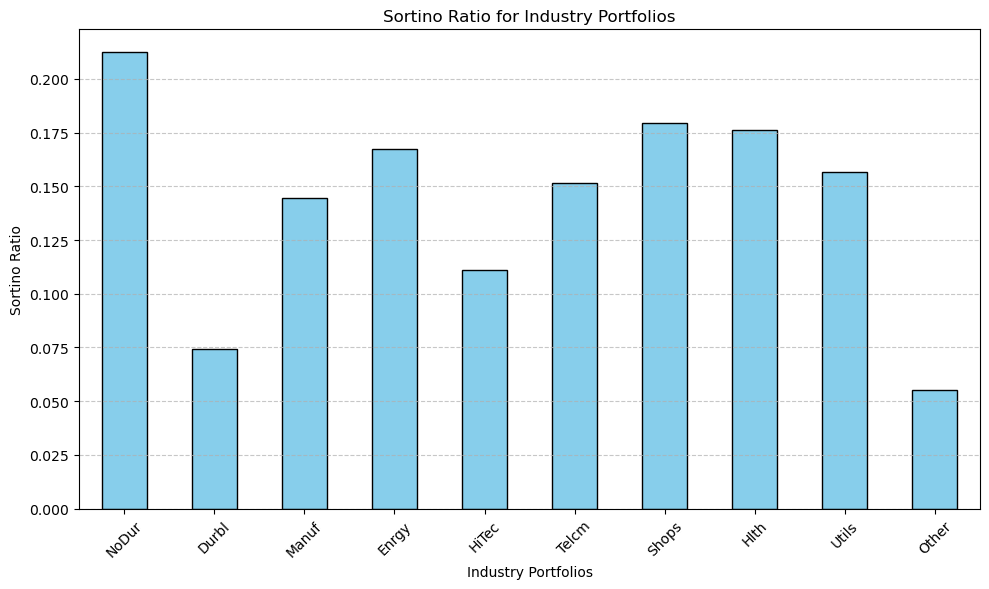

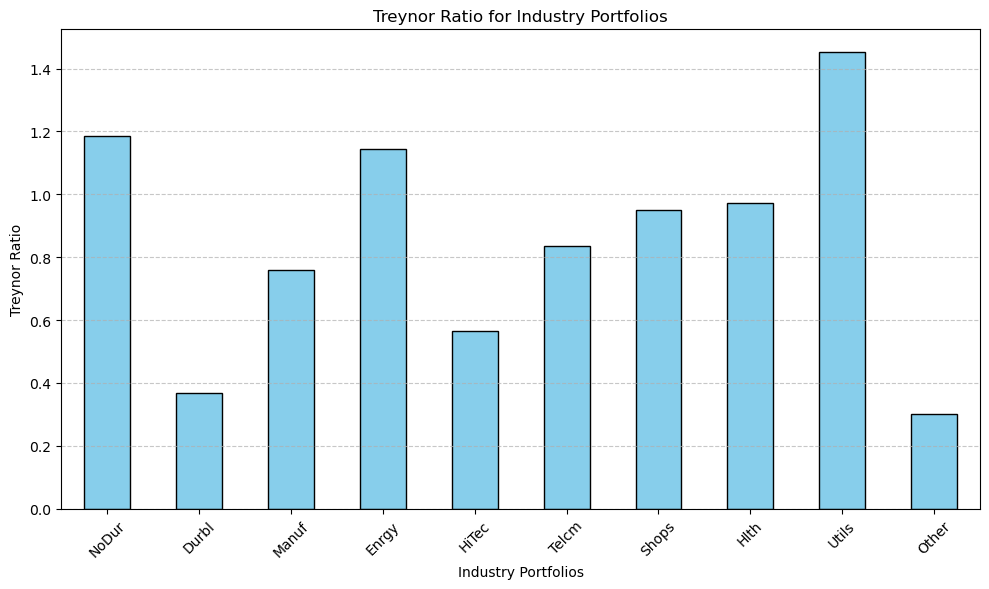

In [3]:

# Calculate Fama-French Three-Factor model coefficients
ff_table = ff3_factor(data_portfolio=df_industries, data_market=df_market, risk_factors=df_risk_factors)

# Calculate CAPM alpha and beta for each industry
industry_excess_returns, capm_betas, jensens_alpha = capm_alpha_beta(
    industry_returns=df_industries, 
    market_returns=df_market, 
    risk_free=df_risk_factors["Rf"]
)

# Calculate various performance metrics including Sharpe, Sortino, Treynor ratios, Jensen's Alpha, and FF Three-Factor Alpha
performance_metrics = calculate_performance_metrics(
    excess_returns=industry_excess_returns,
    risk_factors=df_risk_factors, 
    capm_betas=capm_betas,
    ff_alphas=ff_table["Alpha"]
)

# performance_metrics = calculate_performance_metrics2(
#     excess_returns=industry_excess_returns,
#     risk_factors=rf, 
#     capm_betas=capm_betas,
#     ff_alphas=ff_table["Alpha"],
#     benchmark_returns=#add benchmark returns here
# )    

# Remove the R-squared column from ff_table as it's not needed for performance metrics
ff_table.drop(columns="R-squared", inplace=True)

# Display Fama-French model coefficients and performance metrics
print(ff_table)
print(performance_metrics)

# Define which performance metrics to plot
metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio']
# Generate bar plots for the specified performance metrics
plot_performance_metrics(performance_metrics, metrics_to_plot)

